In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Demo Plan: BigQuery for Agent Plugin + Conversational Analytics

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/haiyuan-eng-google/demo_BQ_agent_analytics_plugin_notebook/blob/main/NY_City_Bike_Agent_Logging.ipynb">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/colab-logo.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/haiyuan-eng-google/demo_BQ_agent_analytics_plugin_notebook/blob/main/NY_City_Bike_Agent_Logging.ipynb">
      <img src="https://raw.githubusercontent.com/googleapis/python-bigquery-dataframes/refs/heads/main/third_party/logo/github-logo.png" width="32" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/haiyuan-eng-google/demo_BQ_agent_analytics_plugin_notebook/main/NY_City_Bike_Agent_Logging.ipynb">
      <img src="https://www.gstatic.com/images/branding/product/1x/google_cloud_48dp.png" alt="Vertex AI logo" width="32">
      Open in Vertex AI Workbench
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/haiyuan-eng-google/demo_BQ_agent_analytics_plugin_notebook/blob/main/NY_City_Bike_Agent_Logging.ipynb">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>
</table>

**_NOTE_**: This notebook has been tested in the following environment:

* Python version = 3.10+

### Costs
This tutorial uses billable components of Google Cloud:
* BigQuery (storage and compute)
* Vertex AI (Gemini models for analysis)

Learn about [BigQuery pricing](https://cloud.google.com/bigquery/pricing) and [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing).

## Environment setup

Complete the tasks in this section to set up your environment.
This section includes
1. Authentication
2. Agent and plugin setup to stream events into BigQuery table
3. Initialize BQ client for further analysis of the agent events

In [ ]:
# Authentication
from google.colab import auth as google_auth
google_auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
# Import Libraries & Initialize Plugin, Tools, Models and Agent
import google.auth
import os
from google.adk.agents import Agent
from google.adk.apps import App
from google.adk.models.google_llm import Gemini
from google.adk.plugins.bigquery_agent_analytics_plugin import BigQueryAgentAnalyticsPlugin
from google.adk.tools.bigquery import BigQueryCredentialsConfig, BigQueryToolset
from google.adk.tools.tool_context import ToolContext

# Configuration
PROJECT_ID = "hyohanna-sandbox"  # @param {type:"string"}
DATASET_ID = "dataset_with_agent_event"  # @param {type:"string"}
TABLE_ID = "public_demo_ny_agent_event_logging"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Ensure environment variables are set for ADK/Vertex AI
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID
os.environ["GOOGLE_CLOUD_LOCATION"] = (
    "us-central1"  # Do not use US or EU since they are not compatible with Vertex AI endpoint
)
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = (
    "True"  # Make sure you have Vertex AI API enabled
)

# --- Initialize the Plugin ---
bq_logging_plugin = BigQueryAgentAnalyticsPlugin(
    project_id=PROJECT_ID,  # project_id is required input from user
    dataset_id=DATASET_ID,  # dataset_id is required input from user
    table_id=TABLE_ID,
    # Optional: defaults to "agent_events". The plugin automatically creates
    # this table if it doesn't exist.
)
print(f"BigQueryAgentAnalyticsPlugin initialized, streaming data to {PROJECT_ID}:{DATASET_ID}.{TABLE_ID}")

# --- Initialize Tools & Model ---
credentials, _ = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
bigquery_toolset = BigQueryToolset(
    credentials_config=BigQueryCredentialsConfig(credentials=credentials)
)

llm = Gemini(
    model="gemini-2.5-flash",
)

def set_state(key: str, value: str, tool_context: ToolContext) -> str:
  """Sets a key-value pair in the session state."""
  tool_context.state[key] = value
  return f"Set state {key} to {value}"


root_agent = Agent(
    model=llm,
    name="my_bq_agent",
    instruction=(
        "You are a helpful assistant with access to BigQuery tools. You can"
        " also set session state using the `set_state` tool."
    ),
    tools=[bigquery_toolset, set_state],
    generate_content_config={
        "temperature": 0.5,
        "top_p": 0.9,
    },
)

# --- Create the App ---
app = App(
    name="my_bq_agent",
    root_agent=root_agent,
    plugins=[bq_logging_plugin], # Register the plugin here
)
print(f"my_bq_agent initialized for project {PROJECT_ID}, dataset {DATASET_ID}")

BigQueryAgentAnalyticsPlugin initialized, streaming data to hyohanna-sandbox:dataset_with_agent_event.public_demo_ny_agent_event_logging
my_bq_agent initialized for project hyohanna-sandbox, dataset dataset_with_agent_event


/usr/local/lib/python3.12/dist-packages/google/adk/features/_feature_decorator.py:72: UserWarning: [EXPERIMENTAL] feature FeatureName.GOOGLE_CREDENTIALS_CONFIG is enabled.
  check_feature_enabled()
/usr/local/lib/python3.12/dist-packages/google/adk/features/_feature_decorator.py:72: UserWarning: [EXPERIMENTAL] feature FeatureName.BIG_QUERY_TOOLSET is enabled.
  check_feature_enabled()
/usr/local/lib/python3.12/dist-packages/google/adk/features/_feature_decorator.py:72: UserWarning: [EXPERIMENTAL] feature FeatureName.BIG_QUERY_TOOL_CONFIG is enabled.
  check_feature_enabled()


In [ ]:
# Import Libraries & Initialize BigQuery Clients
from google.cloud import bigquery
import pandas as pd
import json
import os

# Initialize BigQuery Client
bq_client = bigquery.Client(project=PROJECT_ID, location=LOCATION)
print(f"BigQuery client initialized for project {PROJECT_ID}, dataset {DATASET_ID}")

# Helper function to run BigQuery jobs
def run_bq_query(sql):
    return bq_client.query(sql).to_dataframe()

def run_bq_job(sql):
    bq_client.query(sql).result()
    print("BigQuery job finished.")

BigQuery client initialized for project hyohanna-sandbox, dataset dataset_with_agent_event


## Phase 1: Understand the Agent Logging Table

In [ ]:
### Real-time Feed from my_bq_bot

print("Fetching latest My_bq_bot events...")
query = f"""
SELECT timestamp, event_type, session_id, user_id, TO_JSON_STRING(content) as content, error_message, status
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`

ORDER BY timestamp DESC
LIMIT 20
"""
try:
    df_events = run_bq_query(query)
    print(df_events.to_markdown(index=False))
except Exception as e:
    print(f"Error querying events (maybe run simulation first?): {e}")

Fetching latest My_bq_bot events...
| timestamp                        | event_type           | session_id                           | user_id   | content                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

### Analyze Your Data with **Conversational Analytics**

Why write complex SQL queries from scratch when you can just ask questions?

BigQuery's **Conversational Analytics** allows you to interact with your data using natural language. It doesn't just write the SQL for you—it acts as your data analyst companion by:
1.  **Writing SQL**: Translating your natural language questions into executable SQL queries.
2.  **Generating Insights**: Automatically finding patterns, trends, and anomalies in the results.
3.  **Suggesting Follow-up Questions**: Guiding your analysis with relevant next steps to dig deeper.

Give it a try with the examples below!

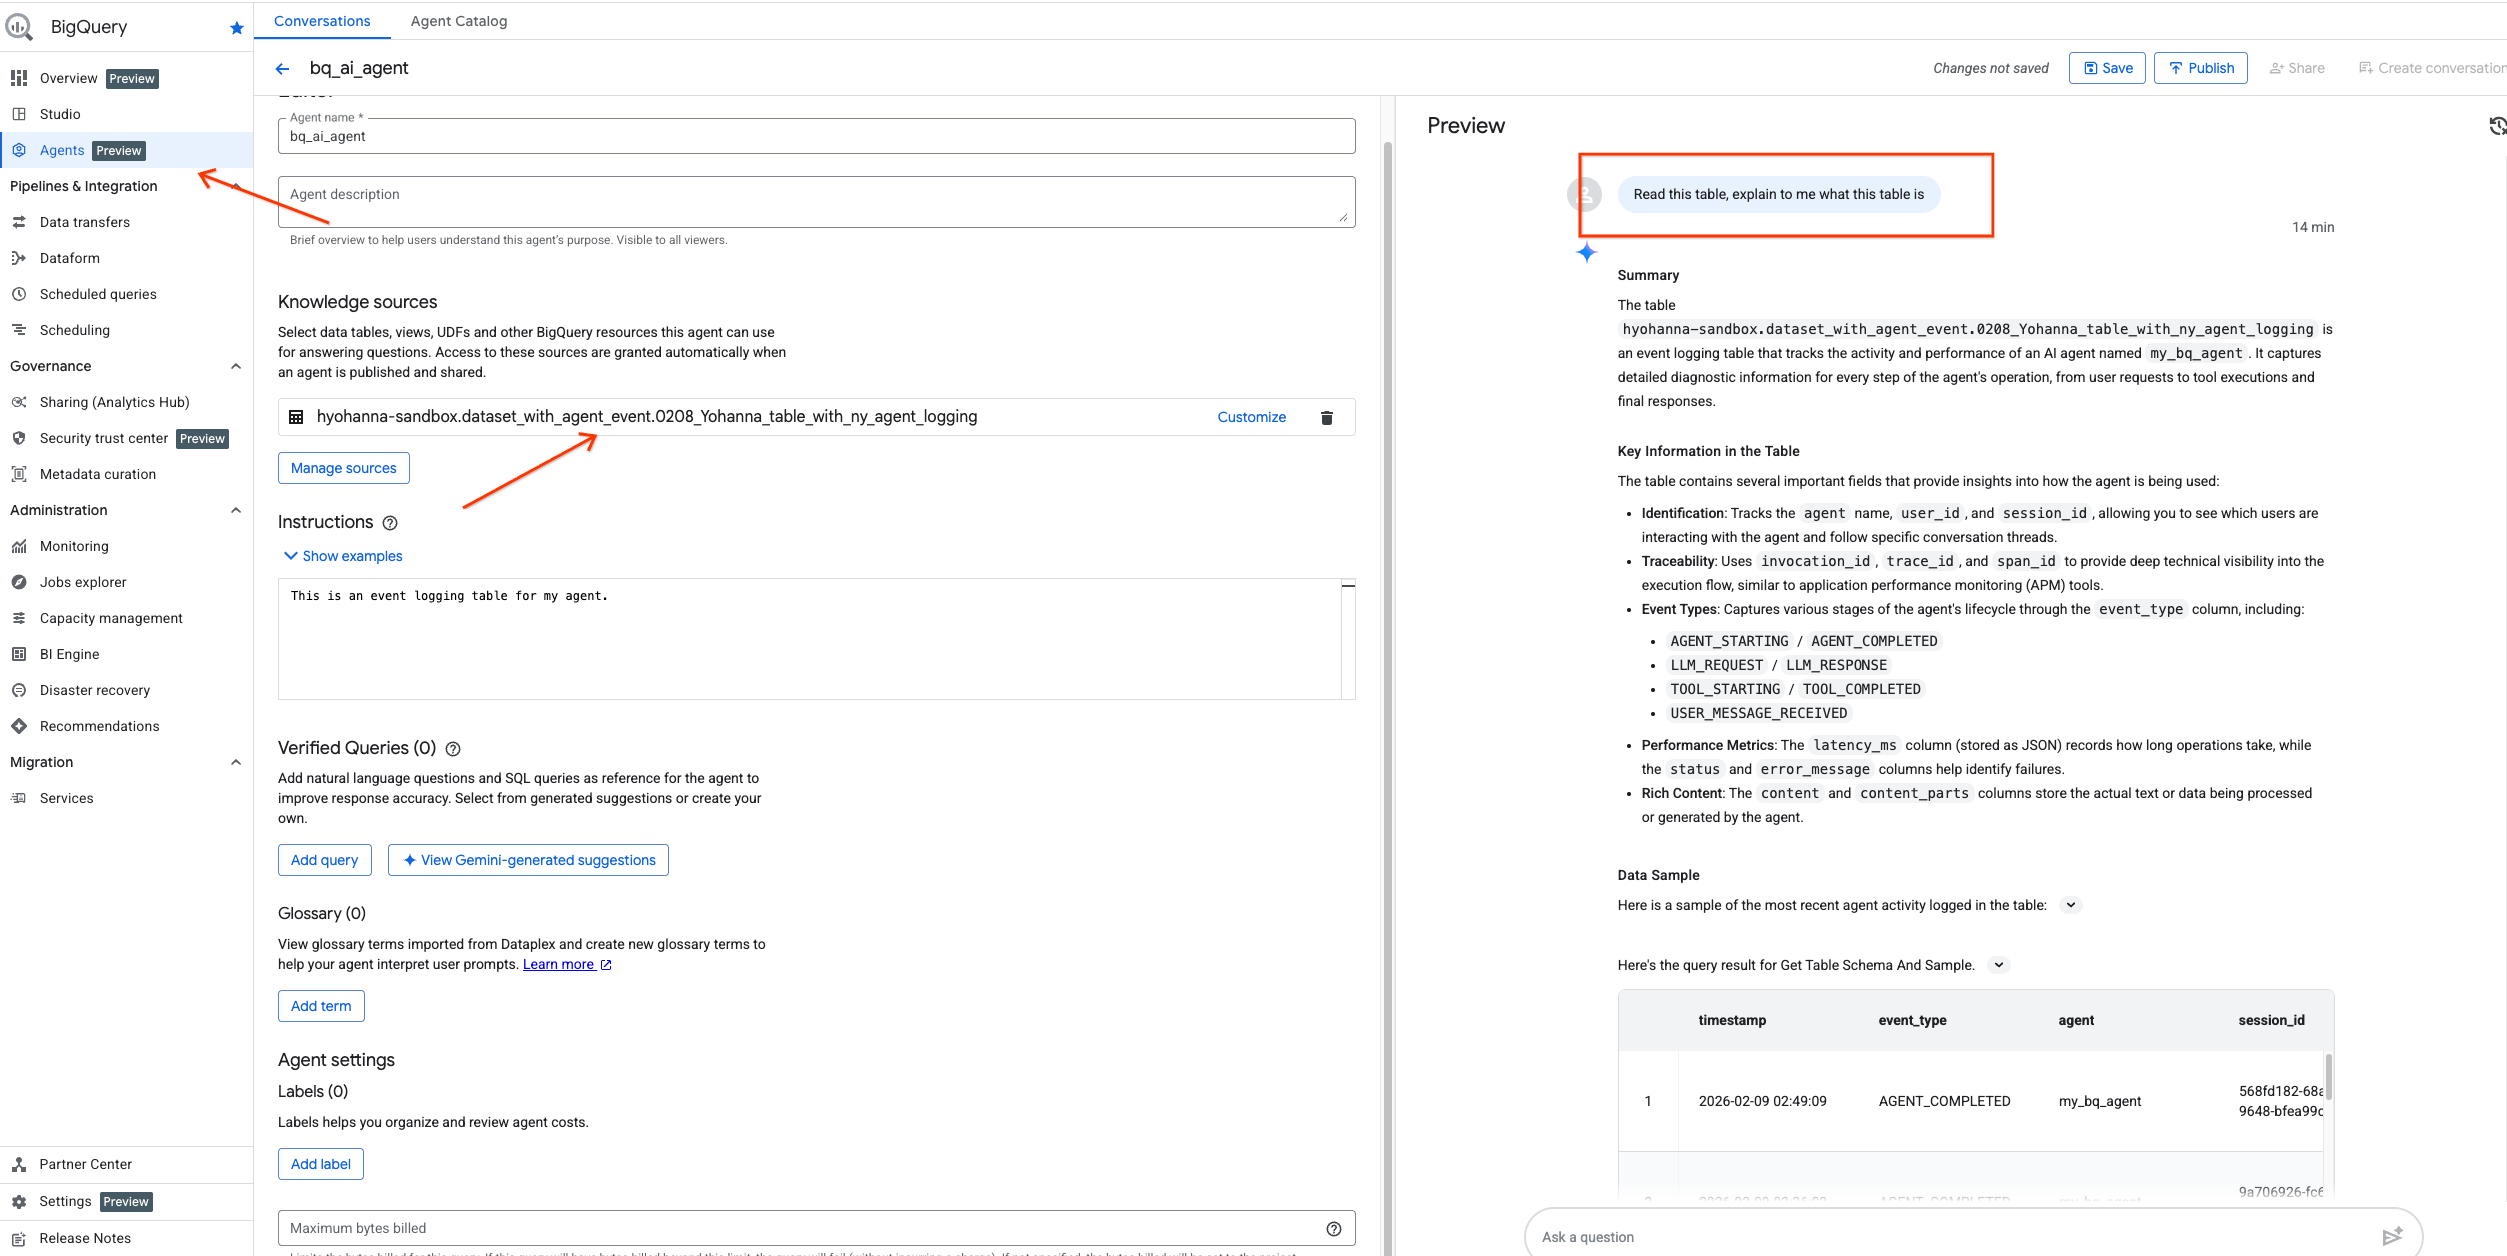

It can even illustrate the possibilities of what you can achieve within BigQuery.

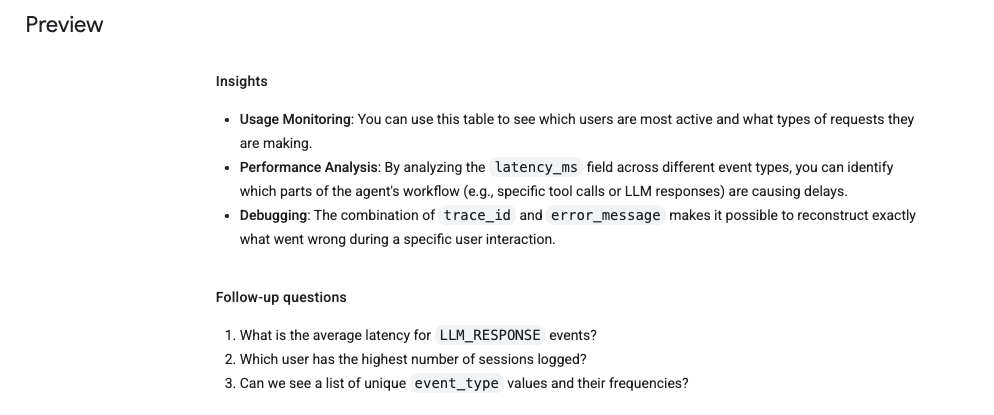

## Phase 2: Some Basic Data Analysis

In [15]:
print("\n--- Usage Monitoring ---")
usage_sql = f"""
SELECT
    DATE(event_logging.timestamp) AS usage_date,
    COUNT(DISTINCT event_logging.user_id) AS unique_active_users,
    COUNT(DISTINCT event_logging.session_id) AS total_sessions,
    COUNTIF(event_logging.event_type = 'INVOCATION_STARTING') AS total_invocations,
    ROUND(AVG(SAFE_CAST(JSON_VALUE(event_logging.latency_ms, '$.total_ms') AS INT64)), 2) AS avg_completion_latency_ms
FROM
    `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}` AS event_logging
GROUP BY
    usage_date
ORDER BY
    usage_date DESC
"""
try:
    df_usage = run_bq_query(usage_sql)
    print(df_usage.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Usage Monitoring ---
| usage_date   |   unique_active_users |   total_sessions |   total_invocations |   avg_completion_latency_ms |
|:-------------|----------------------:|-----------------:|--------------------:|----------------------------:|
| 2026-02-20   |                     2 |                2 |                   5 |                     3033.44 |
| 2026-02-19   |                     3 |                3 |                  20 |                     2707.79 |
| 2026-02-09   |                     6 |                6 |                  26 |                     3991.28 |


### Experience the Power of **Conversational Analytics**

You can obtain the exact same results by simply asking the BigQuery agent: **'Write a SQL query for usage monitoring.'**

Beyond just the code, **Conversational Analytics** provides:
*   **Automatic Insights**: Summaries of key findings (as shown below).
*   **Smart Follow-ups**: Suggestions for what to ask next.

Here is a real example of the output generated by Conversational Analytics for this query:

**Insight**
* **Active Volume:** On February 9, 2026, the system saw its highest activity with 26 total invocations and 6 unique active users, which is more than double the volume of subsequent days.
* **Engagement Depth:** The ratio of invocations to sessions is relatively high (e.g., ~4.3 invocations per session on Feb 9th), suggesting that users are performing multiple tasks or follow-ups within a single interaction.
* **Performance Stability:** The average latency remains fairly consistent, ranging between approximately 2.7 and 4 seconds, indicating stable performance even as volume fluctuates.

**Follow-up questions**
* Which specific users had the highest number of invocations in the last 30 days?
* Can we break down the average latency by event type to see where bottlenecks are?
* Are there any specific hours of the day where invocation volume spikes?

**Note: All the 'Insights' in the sections below are live examples of what Conversational Analytics can generate through simple natural language. Give it a spin!**

In [16]:
# Error Analysis
print("\n--- Error Analysis ---")
error_sql = f"""
SELECT timestamp, session_id, event_type, TO_JSON_STRING(content) as content, error_message
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE agent = 'ShopBot' AND error_message IS NOT NULL
ORDER BY timestamp DESC
LIMIT 10;
"""
try:
    df_errors = run_bq_query(error_sql)
    print(df_errors.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Error Analysis ---
| timestamp   | session_id   | event_type   | content   | error_message   |
|-------------|--------------|--------------|-----------|-----------------|


In [17]:
# Granular Cost Tracking
print("\n--- Granular Cost Tracking ---")
cost_sql = f"""
SELECT
  session_id,
  user_id,
  COUNT(*) as interaction_count,
  -- Approximation: 4 chars per token
  SUM(LENGTH(TO_JSON_STRING(content))) / 4 AS estimated_tokens,
  -- Example cost: $0.0001 per 1k tokens
  ROUND((SUM(LENGTH(TO_JSON_STRING(content))) / 4) / 1000 * 0.0001, 6) AS estimated_cost_usd
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
GROUP BY session_id, user_id
ORDER BY estimated_cost_usd DESC
LIMIT 5;
"""
df_cost = run_bq_query(cost_sql)
print(df_cost.to_markdown(index=False))


--- Granular Cost Tracking ---
| session_id                           | user_id   |   interaction_count |   estimated_tokens |   estimated_cost_usd |
|:-------------------------------------|:----------|--------------------:|-------------------:|---------------------:|
| 763c1db5-c8ac-4ed5-bb53-b3f19952da94 | user3     |                 172 |            61781.5 |             0.006178 |
| 568fd182-68a5-4952-9648-bfea99cc3056 | user2     |                  81 |            22033.2 |             0.002203 |
| a198c956-d7c2-4867-b23c-ba853bf9375a | user5     |                 105 |            17659.8 |             0.001766 |
| aa1e2a17-a924-4ddd-b034-9999c085b9e8 | user7     |                  34 |            16537.5 |             0.001654 |
| 9a706926-fc6b-4db3-a312-9001f1a4efdc | user4     |                  51 |            11253   |             0.001125 |


## Phase 3: Performance Analysis

> 💡 **Pro Tip**: You can also ask Conversational Analytics to write this query for you! Just ask: *"Analyze performance by event type"*

In [18]:
print("\n--- Performance Analysis ---")
performance_sql = f"""
SELECT
    event_type,
    ROUND(AVG(CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64)) / 1000, 2) AS avg_latency_sec,
    ROUND(MAX(CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64)) / 1000, 2) AS max_latency_sec,
    COUNT(*) AS event_count
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE agent = 'my_bq_agent'
  AND latency_ms IS NOT NULL
GROUP BY event_type
ORDER BY avg_latency_sec DESC;
"""
try:
    df_perf = run_bq_query(performance_sql)
    print(df_perf.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Performance Analysis ---
| event_type      |   avg_latency_sec |   max_latency_sec |   event_count |
|:----------------|------------------:|------------------:|--------------:|
| AGENT_COMPLETED |              7.27 |             28.38 |            50 |
| LLM_RESPONSE    |              2.51 |              6.59 |            96 |
| TOOL_COMPLETED  |              1.65 |             23.27 |            74 |


✨ **Insights Generated by Conversational Analytics** ✨
* **LLM Bottlenecks:** LLM_RESPONSE has an average latency of ~2.5 seconds, which is often the primary driver of perceived wait times for users.
* **Long-Tail Latency:** While the average tool execution (TOOL_COMPLETED) is relatively fast at ~1.6 seconds, it has a massive maximum latency spike of ~23.3 seconds. This suggests that specific external tool calls occasionally experience significant delays.
* **Overall Cycle:** The average total time for an agent to complete a request (AGENT_COMPLETED) is approximately 7.3 seconds.

> 💡 **Pro Tip**: You can also ask Conversational Analytics to write this query for you! Just ask: *"Find the slowest tool calls"*

In [22]:
print("\n--- Slowest Tool Calls Analysis ---")
slow_tools_sql = f"""
SELECT
    JSON_VALUE(content, '$.tool') AS tool_name,
    ROUND(SAFE_CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64) / 1000, 2) AS latency_sec,
    timestamp,
    session_id,
    user_id
FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE event_type = 'TOOL_COMPLETED'
  AND agent = 'my_bq_agent'
  AND latency_ms IS NOT NULL
ORDER BY latency_sec DESC
LIMIT 10;
"""
try:
    df_slow = run_bq_query(slow_tools_sql)
    print(df_slow.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Slowest Tool Calls Analysis ---
| tool_name         |   latency_sec | timestamp                        | session_id                           | user_id   |
|:------------------|--------------:|:---------------------------------|:-------------------------------------|:----------|
| ask_data_insights |         23.27 | 2026-02-09 03:51:51.396805+00:00 | aa1e2a17-a924-4ddd-b034-9999c085b9e8 | user7     |
| ask_data_insights |         17.57 | 2026-02-09 03:50:49.799422+00:00 | aa1e2a17-a924-4ddd-b034-9999c085b9e8 | user7     |
| ask_data_insights |         13.68 | 2026-02-09 03:39:18.573275+00:00 | aa1e2a17-a924-4ddd-b034-9999c085b9e8 | user7     |
| ask_data_insights |          6.44 | 2026-02-09 03:37:42.009659+00:00 | 9a706926-fc6b-4db3-a312-9001f1a4efdc | user4     |
| ask_data_insights |          6.1  | 2026-02-09 03:36:01.800984+00:00 | 9a706926-fc6b-4db3-a312-9001f1a4efdc | user4     |
| execute_sql       |          1.72 | 2026-02-20 00:37:45.268033+00:00 | a198c956-d7c2-4867-b23

✨ **Insights Generated by Conversational Analytics** ✨

* **Heaviest Tool:** ask_data_insights is consistently the slowest tool, likely because it involves additional reasoning or summarizing steps compared to a direct SQL execution.
* **Session Focus:** User7's session remains the primary area for performance investigation, as it contains multiple ask_data_insights calls that took over 10 seconds.
* **SQL Efficiency:** SQL Execution calls are generally much faster, typically completing in under 2 seconds.

> 💡 **Pro Tip**: You can also ask Conversational Analytics to write this query for you! Just ask: *"Identify high-latency user questions"*

In [23]:
print("\n--- High-Latency User Questions Analysis ---")
slow_query_sql = f"""
SELECT
    (SELECT text FROM UNNEST(messages.content_parts) WHERE text IS NOT NULL LIMIT 1) AS user_question,
    ROUND(SAFE_CAST(JSON_VALUE(completions.latency_ms, '$.total_ms') AS FLOAT64) / 1000, 2) AS latency_sec,
    messages.timestamp,
    messages.session_id,
    messages.user_id
FROM
    `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}` AS messages
JOIN
    `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}` AS completions
    ON messages.invocation_id = completions.invocation_id
WHERE
    messages.event_type = 'USER_MESSAGE_RECEIVED'
    AND completions.event_type = 'AGENT_COMPLETED'
    AND messages.agent = 'my_bq_agent'
ORDER BY
    latency_sec DESC
LIMIT 10;
"""
try:
    df_slow_queries = run_bq_query(slow_query_sql)
    print(df_slow_queries.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- High-Latency User Questions Analysis ---
| user_question                                                                                                                                                             |   latency_sec | timestamp                        | session_id                           | user_id   |
|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|:---------------------------------|:-------------------------------------|:----------|
| calculate the tip rate, show me the trend                                                                                                                                 |         28.38 | 2026-02-09 03:51:24.870298+00:00 | aa1e2a17-a924-4ddd-b034-9999c085b9e8 | user7     |
| what about the trend in tips                                                                                                

✨ **Insights Generated by Conversational Analytics** ✨

* **Complexity of Trends:** Queries asking for "trends" (e.g., "tip rate trend" or "health trend over the years") consistently appear as high-latency events. This is likely due to the agent having to perform multiple data retrievals and aggregation steps before responding.
* **Large Dataset Scans:** Questions that specify multiple years of data or specific datasets (like tlc_green_trips from 2013-2016) trigger intensive background processes that contribute to the ~22-28 second response times seen for user7.
* **Optimization Opportunity:** The agent spends significant time on "discovery" questions (e.g., "tell me what's in the tables"). Optimizing metadata caching for these specific intents could reduce initial response latency by several seconds.

**Leverage on BigQuery's built-in AI features**

You can also leverage on BigQuery's built-in AI feature to analyze your agent's event logging data. When you do performance analysis, this is particularly useful for Anomaly Detection (e.g., finding unexpected spikes in latency).

* **AI.DETECT_ANOMALIES:** This function can compare your recent activity against a historical baseline. It will flag any data point where the latency or usage falls outside of the expected "normal" range (the lower_bound and upper_bound).

> 💡 **Pro Tip**: You can also ask Conversational Analytics to write this query for you! Just ask: *"Detect latency anomalies in the logs"*

In [37]:
print("\n--- Latency Anomaly Detection (02/09 Only) ---")
anomaly_sql_0209 = f"""
WITH base_data AS (
  SELECT
    DATE_TRUNC(timestamp, MINUTE) AS event_minute,
    AVG(CAST(JSON_VALUE(latency_ms, '$.total_ms') AS FLOAT64)) AS avg_latency_ms
  FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
  WHERE agent = 'my_bq_agent'
    AND event_type = 'AGENT_COMPLETED'
    AND latency_ms IS NOT NULL
    AND DATE(timestamp) = '2026-02-09'
  GROUP BY 1
),
historical_data AS (
  SELECT event_minute, avg_latency_ms FROM base_data
  WHERE event_minute < '2026-02-09 03:50:00'
),
target_data AS (
  SELECT event_minute, avg_latency_ms FROM base_data
  WHERE event_minute >= '2026-02-09 03:50:00'
)
SELECT
  time_series_timestamp,
  time_series_data,
  is_anomaly,
  lower_bound,
  upper_bound,
  anomaly_probability
FROM
  AI.DETECT_ANOMALIES(
    (SELECT * FROM historical_data),
    (SELECT * FROM target_data),
    data_col => 'avg_latency_ms',
    timestamp_col => 'event_minute'
  )
ORDER BY time_series_timestamp DESC;
"""
try:
    df_anomalies_0209 = run_bq_query(anomaly_sql_0209)
    print(df_anomalies_0209.to_markdown(index=False))
except Exception as e:
  print(f"Error: {e}")


--- Latency Anomaly Detection (02/09 Only) ---
| time_series_timestamp     |   time_series_data | is_anomaly   |   lower_bound |   upper_bound |   anomaly_probability |
|:--------------------------|-------------------:|:-------------|--------------:|--------------:|----------------------:|
| 2026-02-09 03:53:00+00:00 |               5982 | False        |      -2135.43 |       48172   |              0.497746 |
| 2026-02-09 03:51:00+00:00 |              28379 | False        |      -3007.7  |       49576.5 |              0.61526  |
| 2026-02-09 03:50:00+00:00 |              24935 | False        |      -3259.99 |       50828.7 |              0.482176 |


✨ **Insights Generated by Conversational Analytics** ✨
* **Statistical Normality:** Despite the average latency reaching 28.3 seconds at 03:51 AM, the model did not flag this as an anomaly (is_anomaly = false).
* **High Confidence Bounds:** The upper_bound for expected latency is very high (approx. 49 seconds). This indicates that because the agent handles varied and complex queries (like the multi-year taxi analysis we found earlier), a wide range of response times is considered "statistically normal" for this specific workload.
* **Probability:** The anomaly probability for the 03:51 AM spike was 0.61, which is elevated but below the default threshold (usually 0.95 or 0.99) required to trigger a formal anomaly flag.

Of course, you can always lower the anomaly threshold to be more sensitive to delays.

## Phase 4: Understand and Protect Your User

To run a successful agent, sometimes you want to understand your user better. BigQuery's AI feature can help transform raw log data into structured insights without needing external machine learning pipelines.


In [45]:
print("\n--- AI-Driven User Intent Analysis ---")
ai_user_analysis_sql = f"""
WITH user_messages AS (
  SELECT
    timestamp,
    user_id,
    JSON_VALUE(content, '$.text_summary') AS raw_message
  FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
  WHERE agent = 'my_bq_agent'
    AND event_type = 'USER_MESSAGE_RECEIVED'
    AND JSON_VALUE(content, '$.text_summary') IS NOT NULL
  ORDER BY timestamp DESC
  LIMIT 50
)
SELECT
  timestamp,
  user_id,
  raw_message,
  -- Generate a short summary of the user's question
  AI.GENERATE(
    CONCAT('Summarize this user request in 5 words or less: ', raw_message)
  ).result AS ai_summary,
  -- Categorize the message into predefined intent buckets
  AI.CLASSIFY(
    raw_message,
    categories => ['Trend Analysis', 'Data Exploration', 'Location Service', 'Security', 'Other']
  ) AS ai_intent
FROM user_messages;
"""
try:
    df_ai_analysis = run_bq_query(ai_user_analysis_sql)
    print(df_ai_analysis.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")



--- AI-Driven User Intent Analysis ---
| timestamp                        | user_id   | raw_message                                                                                                                                                               | ai_summary                          | ai_intent        |
|:---------------------------------|:----------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------|:-----------------|
| 2026-02-09 03:25:45.331059+00:00 | user6     | 483794900732 for project, demo_with_sample_ny_datasets for dataset, table id is citibike_stations                                                                         | Project, dataset, table details.    | Data Exploration |
| 2026-02-19 22:57:11.453495+00:00 | user3     | how are the tree's health                                                    

* **AI.CLASSIFY:** The AI.CLASSIFY function successfully distinguished between "Trend Analysis" (e.g., fare trends) and "Data Exploration" (e.g., fare amount), allowing you to see exactly which features of your agent are most popular.
* **AI.GENERATE:** The AI.GENERATE function condensed a long list of specific table names (from the 03:35 AM request) into a simple summary: "Analyze green trips, 2013-2016." This makes high-level reporting much cleaner.


> 💡 **Pro Tip**: You can also ask Conversational Analytics to write this query for you! Just ask: *"Use AI.CLASSIFY to analyze the intent volume versus performance"*

In [46]:
print("\n--- AI Intent: Volume vs. Performance Analysis ---")
intent_perf_sql = f"""
WITH classified_intents AS (
  SELECT
    AI.CLASSIFY(
      input => (SELECT text FROM UNNEST(messages.content_parts) WHERE text IS NOT NULL LIMIT 1),
      categories => ['Trend Analysis', 'Data Exploration', 'Location Service', 'Security', 'Other']
    ) AS intent,
    SAFE_CAST(JSON_VALUE(completions.latency_ms, '$.total_ms') AS FLOAT64) / 1000 AS latency_sec
  FROM
    `{{PROJECT_ID}}.{{DATASET_ID}}.{{TABLE_ID}}` AS messages
  JOIN
    `{{PROJECT_ID}}.{{DATASET_ID}}.{{TABLE_ID}}` AS completions
    ON messages.invocation_id = completions.invocation_id
  WHERE
    messages.event_type = 'USER_MESSAGE_RECEIVED'
    AND completions.event_type = 'AGENT_COMPLETED'
    AND messages.agent = 'my_bq_agent'
)
SELECT
  intent,
  COUNT(*) AS intent_volume,
  ROUND(AVG(latency_sec), 2) AS avg_latency_sec
FROM
  classified_intents
GROUP BY
  intent
ORDER BY
  intent_volume DESC;
""".format(PROJECT_ID=PROJECT_ID, DATASET_ID=DATASET_ID, TABLE_ID=TABLE_ID)
try:
    df_intent_perf = run_bq_query(intent_perf_sql)
    print(df_intent_perf.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- AI Intent: Volume vs. Performance Analysis ---
| intent           |   intent_volume |   avg_latency_sec |
|:-----------------|----------------:|------------------:|
| Data Exploration |              29 |              6.68 |
| Other            |               8 |              3.11 |
| Trend Analysis   |               7 |             17.14 |
| Location Service |               5 |              3.82 |
| Security         |               1 |              5.98 |


✨ **Insights Generated by Conversational Analytics** ✨

* **Complexity and Latency:** Trend Analysis has the highest average latency at 17.14 seconds, despite a relatively low volume (7 occurrences). This confirms that analytical trend-based queries are the most computationally intensive for the agent.
* **Primary Use Case:** Data Exploration is by far the most frequent intent (29 occurrences), with a moderate average latency of 6.68 seconds. This suggests that users primarily use the agent for initial data discovery and inspection.
* **Lightweight Intents:** Location Service and Other (General Chat) are significantly faster, with latencies around 3-4 seconds.

Based on this sample, Data Exploration and Trend Analysis are the most common reasons users interact with your agent, suggesting you should prioritize optimizing the performance for those specific tasks.

You want to protect your customer from data leak and improve PII detection. So let's take a look at one interesting user whose question is security related.

> 💡 **Pro Tip**: You can also ask Conversational Analytics to write this query for you! Just ask: *"Find users asking security-related questions"*

In [48]:
print("\n--- Security-Related User Questions ---")
security_questions_sql = f"""
WITH classified_messages AS (
  SELECT
    event_logging.user_id,
    (SELECT text FROM UNNEST(event_logging.content_parts) WHERE text IS NOT NULL LIMIT 1) AS user_message,
    event_logging.timestamp,
    AI.CLASSIFY(
      input => (SELECT text FROM UNNEST(event_logging.content_parts) WHERE text IS NOT NULL LIMIT 1),
      categories => ['Trend Analysis', 'Data Exploration', 'Location Service', 'Security', 'Other']
    ) AS intent
  FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}` AS event_logging
  WHERE
    event_logging.event_type = 'USER_MESSAGE_RECEIVED'
    AND event_logging.agent = 'my_bq_agent'
)
SELECT
  user_id,
  user_message,
  timestamp,
  intent
FROM
  classified_messages
WHERE
  intent = 'Security'
ORDER BY
  timestamp DESC;

"""
try:
    df_sec_questions = run_bq_query(security_questions_sql)
    print(df_sec_questions.to_markdown(index=False))
except Exception as e:
    print(f"Error: {e}")


--- Security-Related User Questions ---
| user_id   | user_message                                                                     | timestamp                        | intent   |
|:----------|:---------------------------------------------------------------------------------|:---------------------------------|:---------|
| user9     | which table in project 483794900732 potentially contains personal/sensitive data | 2026-02-09 03:53:14.131343+00:00 | Security |


✨ **Insights Generated by Conversational Analytics** ✨

* **Specific Interest:** Only user9 has been identified as having asked a security-related question, which was about identifying sensitive or personal data in a specific project.
* **Risk Assessment:** This kind of question could indicate that the user is trying to identify potential security vulnerabilities or data privacy risks within the available datasets.
* **Agent Responsibility:** It is important to monitor these types of queries to ensure that the agent does not inadvertently expose sensitive data or provide information that could lead to a security breach.

The **AI.CLASSIFY** feature successfully flagged this as a Security intent, which allows you to filter for such risks even if users don't use obvious keywords in the future.

Now let's review our agent's response, make sure no PII is leaked.

> 💡 **Pro Tip**: You can also ask Conversational Analytics to write this query for you! Just ask: *"Identify potential PII in agent responses. Filter for rows where any PII field is NOT NULL"*

In [54]:
print("\n--- Security Audit: PII Detection in Agent Responses ---")
agent_pii_audit_sql = f"""
WITH pii_extraction AS (
  SELECT
    JSON_VALUE(event_logging.content, '$.response') AS agent_response,
    AI.GENERATE(
      prompt => CONCAT(
        'Extract any PII from the following text and return it as a JSON object with keys "name", "email", and "phone". ',
        'If a field is not found, use the string "None" as the value. Text: ',
        JSON_VALUE(event_logging.content, '$.response')
      )
    ).result AS extracted_pii_json,
    event_logging.timestamp,
    event_logging.user_id,
    event_logging.session_id
  FROM
    `{{PROJECT_ID}}.{{DATASET_ID}}.{{TABLE_ID}}` AS event_logging
  WHERE
    event_logging.event_type = 'LLM_RESPONSE'
    AND JSON_VALUE(event_logging.content, '$.response') IS NOT NULL
),
pii_fields AS (
  SELECT
    agent_response,
    JSON_VALUE(extracted_pii_json, '$.name') AS pii_name,
    JSON_VALUE(extracted_pii_json, '$.email') AS pii_email,
    JSON_VALUE(extracted_pii_json, '$.phone') AS pii_phone,
    timestamp,
    user_id,
    session_id
  FROM
    pii_extraction
)
SELECT
  *
FROM
  pii_fields
WHERE
  (pii_name IS NOT NULL AND LOWER(pii_name) != 'none')
  OR (pii_email IS NOT NULL AND LOWER(pii_email) != 'none')
  OR (pii_phone IS NOT NULL AND LOWER(pii_phone) != 'none')
ORDER BY
  timestamp DESC;
""".format(PROJECT_ID=PROJECT_ID, DATASET_ID=DATASET_ID, TABLE_ID=TABLE_ID)

try:
    df_pii = run_bq_query(agent_pii_audit_sql)
    if df_pii.empty:
        print("No rows containing potential PII were found.")
    else:
        print(df_pii.to_markdown(index=False))
except Exception as e:
    print(f"Error: {{e}}")


--- Security Audit: PII Detection in Agent Responses ---
No rows containing potential PII were found.
